In [1]:
from collections import defaultdict
from copy import deepcopy
from dataclasses import dataclass, field
from enum import IntEnum
from functools import cached_property
from typing import Optional, Sequence, Iterator, Dict, Set, TypeVar, Union, MutableSequence

import clingo
from clingraph import Factbase, compute_graphs


In [2]:

ForwardSymbol = TypeVar('ForwardSymbol', bound='Symbol')

@dataclass(order=True, frozen=True)
class Symbol:
    name: Optional[str] = field(default=None)
    arguments: Sequence[ForwardSymbol] = field(default_factory=tuple)

    def __str__(self):
        if self.name is None:
            return '({})'.format(','.join(map(str, self.arguments)))
        elif not self.arguments:
            return self.name
        else:
            return '{}({})'.format(self.name, ','.join(map(str, self.arguments)))

In [3]:


@dataclass(order=True, frozen=True)
class Atom:
    symbol: Symbol = field(default_factory=Symbol)

    def __str__(self):
        return str(self.symbol)


In [4]:


class Sign(IntEnum):
    NoSign = 0
    Negation = 1

    def __str__(self):
        if self is Sign.NoSign:
            return ''
        elif self is Sign.Negation:
            return 'not'
        else:
            assert False, 'Unknown IntEnum {} = {}.'.format(self.name, self.value)


In [5]:

@dataclass(order=True, frozen=True)
class Literal:
    sign: Sign = Sign.NoSign
    atom: Atom = field(default_factory=Atom)

    def __str__(self):
        if self.sign is Sign.NoSign:
            return "{}".format(self.atom)
        else:
            return "{} {}".format(self.sign, self.atom)

    def __neg__(self):
        return Literal(Sign((self.sign ^ 1) % 2), self.atom)

    def __abs__(self):
        return Literal(Sign.NoSign, self.atom)

    @property
    def is_pos(self) -> bool:
        return self.sign is Sign.NoSign

    @property
    def is_neg(self) -> bool:
        return self.sign is Sign.Negation


In [6]:

class Rule:

    @property
    def head(self) -> Literal:
        if hasattr(self, '_head'):
            return getattr(self, '_head')
        raise NotImplementedError

    @property
    def body(self) -> Sequence[Literal]:
        if hasattr(self, '_body'):
            return getattr(self, '_body')
        raise NotImplementedError

    @staticmethod
    def fmt_body(body: Sequence[Literal]):
        return ', '.join(map(str, body))


In [7]:

@dataclass(order=True, frozen=True)
class NormalRule(Rule):
    _head: Literal = field(default_factory=Literal)
    _body: Sequence[Literal] = ()

    @property
    def head(self) -> Literal:
        return self._head

    @property
    def body(self) -> Sequence[Literal]:
        return self._body

    def __str__(self):
        if self.body:
            return "{} :- {}.".format(self.head, Rule.fmt_body(self.body))
        else:
            return "{}.".format(self.head)

In [8]:


@dataclass(order=True, frozen=True)
class Goal(Rule):
    _body: Sequence[Literal] = ()

    @property
    def head(self):
        return True

    @property
    def body(self) -> Sequence[Literal]:
        return self._body

    def __str__(self):
        if self.body:
            return '#true :- {}.'.format(Rule.fmt_body(self.body))
        else:
            return '#true.'

In [9]:


_ForwardBaseNode = TypeVar('_ForwardBaseNode', bound='_BaseNode')


@dataclass
class _BaseNode:
    subject: Union[Literal, Rule, None]
    hypotheses: Set[Literal]
    parent: Optional[_ForwardBaseNode]
    children: MutableSequence[_ForwardBaseNode]
    index: int

    @property
    def is_expanded(self):
        return self.children is not None

    @property
    def is_root(self):
        return self.parent is None

    @property
    def is_leaf(self):
        return self.is_expanded and not self.children

    @property
    def is_complete(self) -> bool:
        return False

    def is_exhausted(self, rules: Sequence[Rule]) -> bool:
        raise NotImplementedError

    def expand_all(self, rules: Sequence[Rule]) -> Sequence[_ForwardBaseNode]:
        raise NotImplementedError

    def expand(self, rules: Sequence[Rule]) -> Optional[_ForwardBaseNode]:
        raise NotImplementedError

    def propagate_parent(self) -> _ForwardBaseNode:
        return self.parent

    def cleanup(self):
        if self.children is not None:
            for child in self.children:
                child.hypotheses = self.hypotheses
                child.cleanup()

In [10]:


@dataclass
class Node(_BaseNode):
    subject: Union[Literal, Rule, None] = field(default=None)
    hypotheses: Set[Literal] = field(default_factory=set)
    parent: Optional[_BaseNode] = field(default=None)
    children: Optional[MutableSequence[_BaseNode]] = field(default=None)
    index: int = field(default=0)
    position: int = field(default=0)


ForwardAndNode = TypeVar('ForwardAndNode', bound='AndNode')


In [11]:

@dataclass
class OrNode(Node):
    subject: Optional[Literal] = field(default=None)
    children: Optional[MutableSequence[ForwardAndNode]] = field(default=None)
    unfounded: bool = field(default=False)

    def __str__(self):
        return "Or({}): {} {}".format(self.subject, self.index, self.is_complete)

    @property
    def is_complete(self) -> bool:
        return self.is_expanded and not self.unfounded and self.subject in self.hypotheses

    def is_exhausted(self, rules: Sequence[Rule]) -> bool:
        return self.index >= len(rules)

    def expand_all(self, rules: Sequence[Rule]) -> Sequence[ForwardAndNode]:
        self.children = []
        for rule in rules:
            if rule.head != self.subject:
                continue
            if any(-body_literal in self.hypotheses for body_literal in rule.body):
                continue
            hypotheses = deepcopy(self.hypotheses)
            hypotheses.add(self.subject)
            child = AndNode(subject=rule, hypotheses=hypotheses, parent=self)
            self.children.append(child)
        return self.children

    def expand(self, rules: Sequence[Rule]) -> Optional[ForwardAndNode]:
        assert self.subject is not None
        if not self.is_expanded:
            self.children = []
        if self.is_exhausted(rules):
            return None
        if self.unfounded:
            return None
        if -self.subject in self.hypotheses:
            return None
        if self.subject in self.hypotheses:
            node = self
            while not node.parent.is_root and node.subject.is_pos:
                node = node.parent.parent
                if node.subject == self.subject:
                    self.unfounded = True
                    return None

        rule = rules[self.index]
        if rule.head != self.subject:
            return None
        if any(-body_literal in self.hypotheses for body_literal in rule.body):
            return None
        hypotheses = deepcopy(self.hypotheses)
        hypotheses.add(self.subject)
        child = AndNode(subject=rule, hypotheses=hypotheses, parent=self)
        self.children.append(child)
        return child

    def propagate_parent(self) -> ForwardAndNode:
        hypotheses = deepcopy(self.hypotheses)
        parent = AndNode(subject=self.parent.subject,
                         hypotheses=hypotheses,
                         parent=self.parent.parent,
                         children=self.parent.children,
                         index=self.parent.index + 1)
        self.parent = parent
        return parent

In [12]:


@dataclass
class AndNode(Node):
    subject: Optional[Rule] = field(default=None)
    children: Optional[MutableSequence[OrNode]] = field(default=None)

    def __str__(self):
        return "And({}): {} {}".format(self.subject, self.index, self.is_complete)

    @property
    def is_complete(self) -> bool:
        return self.is_exhausted() and all(body_literal in self.hypotheses for body_literal in self.subject.body)

    def is_exhausted(self, rules: Sequence[Rule] = ()) -> bool:
        return self.index >= len(self.subject.body)

    def expand_all(self, rules: Sequence[Rule]) -> Sequence[OrNode]:
        self.children = []
        for body_literal in self.subject.body:
            if body_literal in self.hypotheses:
                continue
            hypotheses = deepcopy(self.hypotheses)
            child = OrNode(subject=body_literal, hypotheses=hypotheses, parent=self)
            self.children.append(child)
        return self.children

    def expand(self, rules: Sequence[Rule]) -> Optional[OrNode]:
        if not self.is_expanded:
            self.children = []
        if self.is_exhausted(rules):
            return None
        body_literal = self.subject.body[self.index]
        if body_literal.is_neg and body_literal in self.hypotheses:
            return None
        hypotheses = deepcopy(self.hypotheses)
        child = OrNode(subject=body_literal,
                       hypotheses=hypotheses,
                       parent=self)
        self.children.append(child)
        return child

    def propagate_parent(self) -> OrNode:
        hypotheses = deepcopy(self.hypotheses)
        parent = OrNode(subject=self.parent.subject,
                        hypotheses=hypotheses,
                        parent=self.parent.parent,
                        children=self.parent.children,
                        index=self.parent.index + 1)
        self.parent = parent
        return parent


In [13]:

@dataclass(order=True, frozen=True)
class Program:
    rules: Sequence[Rule] = ()

    def fmt(self, sep=' ', begin=None, end=None):
        b = begin + sep if begin is not None else ''
        e = sep + end if end is not None else ''
        return "{}{}{}".format(b, sep.join(map(str, self.rules)), e)

    def __str__(self):
        return self.fmt()

    @cached_property
    def dual(self):  # type Program
        return Program.dual_of(self.rules)

    @cached_property
    def sASP(self):
        sasp_rules = list(self.rules)
        sasp_rules.extend(self.dual_of(tuple(self.non_constraint_rules)).rules)

        chk_rules = []
        nmr_chk_head = Literal(atom=Atom(Symbol("__nmr_chk")))
        nmr_chk_body = []
        for i, c_rule in enumerate(self.constraint_rules):
            chk_head = Literal(atom=Atom(Symbol("__chk_{}_{}".format(c_rule.head.atom.symbol.name, i))))
            chk_rule_ = NormalRule(chk_head, (c_rule.head,))
            chk_rules_ = (NormalRule(chk_head, (-body_literal,)) for body_literal in c_rule.body if
                          c_rule.body != -c_rule.head)
            chk_rules.append(chk_rule_)
            chk_rules.extend(chk_rules_)
            nmr_chk_body.append(chk_head)

        sasp_rules.extend(chk_rules)
        nmr_chk_rule = NormalRule(nmr_chk_head, nmr_chk_body)
        sasp_rules.append(nmr_chk_rule)
        return Program(rules=sasp_rules)

    @cached_property
    def reachable(self) -> Dict[Rule, Set[Literal]]:
        reachable = defaultdict(set)
        for rule in self.rules:
            if not rule.body:
                reachable[rule] = set()
                continue
            considered = set()
            literal_stack = []
            naf_stack = []
            literal_stack.extend(rule.body)
            naf_stack.extend([0 for _ in rule.body])
            while literal_stack:
                literal = literal_stack.pop()
                naf = naf_stack.pop()
                naf = (naf + literal.is_neg) % 2
                reachable[rule].add(Literal(Sign(naf), literal.atom))
                for adj in self.rules:
                    if adj not in considered and adj.head == abs(literal):
                        considered.add(adj)
                        literal_stack.extend(adj.body)
                        naf_stack.extend([naf for _ in adj.body])
        return reachable

    @property
    def constraint_rules(self) -> Iterator[Rule]:
        for rule, reachable in self.reachable.items():
            if -rule.head in reachable:
                yield rule

    @property
    def non_constraint_rules(self) -> Iterator[Rule]:
        for rule, reachable in self.reachable.items():
            if rule.head in reachable or -rule.head not in reachable:
                yield rule

    def evaluate_top_down(self, *literals: Literal) -> Iterator[Node]:
        __nmr_chk = Literal(atom=Atom(Symbol("__nmr_chk")))
        goal = Goal((*literals, __nmr_chk))
        root = AndNode(subject=goal)
        rules = self.sASP.rules
        derivation_stack = [root]
        while derivation_stack:
            current = derivation_stack.pop()
            if current.is_complete:
                if current.is_root:
                    yield deepcopy(current)
                else:
                    new_parent = current.propagate_parent()
                    derivation_stack.append(new_parent)
            elif not current.is_exhausted(rules):
                child = current.expand(rules)
                if child is None:
                    current.index += 1
                    derivation_stack.append(current)
                else:
                    if isinstance(current, OrNode):
                        current.index += 1
                        derivation_stack.append(current)
                    derivation_stack.append(child)

    @staticmethod
    def dual_of(rules):
        dual_rules = []
        b2n: Dict[Sequence[Literal], int] = {(): 0}
        n2b: Dict[int, Sequence[Literal]] = {0: ()}
        n2h: Dict[int, Set[Literal]] = {}
        h2n: Dict[Literal, Set[int]] = {}
        ib: Set[Literal] = set()
        n = 0
        for rule in rules:
            head = rule.head
            body = tuple(sorted(set(rule.body)))
            if body not in b2n:
                n += 1
                b2n[body] = n
                n2b[n] = body
            m = b2n[body]
            n2b[m] = body
            n2h.setdefault(m, set()).add(head)
            h2n.setdefault(head, set()).add(m)
        for h, ns in h2n.items():
            dual_head = -h
            dual_body = []
            dual_rule = None
            if ns and not any(n == 0 for n in ns):
                for n in ns:
                    b: Sequence[Literal] = n2b[n]
                    if len(b) == 1:
                        if -b[0] not in dual_body:
                            dual_body.append(-b[0])
                        ib.add(abs(b[0]))
                        dual_rule = NormalRule(dual_head, tuple(dual_body))
                    else:
                        assert len(b) > 1
                        if len(h2n[h]) == 1:
                            support_rule_head = -h
                            for l in b:
                                support_rule_body = (-l,)
                                support_rule = NormalRule(support_rule_head, support_rule_body)
                                dual_rules.append(support_rule)
                        else:
                            __b_n = Literal(atom=Atom(Symbol('__body', (Symbol(str(n)),))))
                            dual_body.append(-__b_n)
                            support_rule_head = -__b_n
                            for l in b:
                                ib.add(abs(l))
                                support_rule_body = (-l,)
                                support_rule = NormalRule(support_rule_head, support_rule_body)
                                dual_rules.append(support_rule)
                            dual_rule = NormalRule(dual_head, tuple(dual_body))

            if dual_rule is not None:
                dual_rules.append(dual_rule)
        for l in ib:
            if l not in h2n:
                dual_rules.append(NormalRule(-l))

        return Program(rules=dual_rules)

In [14]:
def solve(p: Program, *literals: Literal, models=None):
    i = 0
    proofs_gen = p.evaluate_top_down(*literals)
    proofs = []
    while models is None or i < models:
        proof = next(proofs_gen, None)
        if proof is None:
            break
        proofs.append(proof)
        print("Answer {}:".format(i), end=' ')
        print("{")
        print('\n'.join(map(str, sorted(proof.hypotheses))))
        if not proof.hypotheses:
            print(' ', end='')
        print("}")
        i += 1
    if not proofs:
        print("UNSAT")
    else:
        print("SAT {}+".format(len(proofs)))
    return proofs


def explain(proof: Node, indent=0):
    if isinstance(proof.subject, Goal):
        print('*', end='')
    print('-- ', end='')
    print(proof.subject)
    if proof.children is not None:
        for child in proof.children:
            print('  ' * indent + '|')
            print('  ' * indent + '|', end='')
            explain(child, indent + 1)
    else:
        print('  ' * indent + '|')
        print('  ' * indent + '|', end='')
        if proof.is_complete:
            print('--[]')
        else:
            print('--X')


def explanation_graph(proof: Node):
    rules = []
    fb = Factbase()
    stack = [(clingo.Number(0), proof)]
    while stack:
        nr, current = stack.pop()
        string = clingo.String(str(current.subject))
        node = clingo.Function('node', (nr,))
        attr = clingo.Function('attr', (clingo.Function('node'), nr, clingo.Function('label'), string))
        rules.append("{}.".format(attr))
        if isinstance(current, AndNode):
            attr = clingo.Function('attr',
                                   (clingo.Function('node'), nr, clingo.Function('shape'), clingo.Function('box')))
            rules.append("{}.".format(attr))
        elif isinstance(current, OrNode) and current.subject.is_neg:
            attr = clingo.Function('attr', (
                clingo.Function('node'), nr, clingo.Function('fontcolor'), clingo.Function('white')))
            rules.append("{}.".format(attr))
            attr = clingo.Function('attr',
                                   (clingo.Function('node'), nr, clingo.Function('color'), clingo.Function('black')))
            rules.append("{}.".format(attr))
            attr = clingo.Function('attr',
                                   (clingo.Function('node'), nr, clingo.Function('style'), clingo.Function('filled')))
            rules.append("{}.".format(attr))
        rules.append('{}.'.format(node))
        if current.children is not None:
            for i, child in enumerate(current.children):
                cnr = clingo.Tuple_((nr, clingo.Number(i)))
                e = clingo.Tuple_((nr, cnr), )
                edge = clingo.Function('edge', (e,))
                attr = clingo.Function('attr',
                                       (clingo.Function('edge'), e, clingo.Function('dir'), clingo.Function('forward')))
                rules.append("{}.".format(edge))
                rules.append("{}.".format(attr))
                stack.append((cnr, child))
    fb.add_fact_string('\n'.join(rules))
    graphs = compute_graphs(fb)
    return graphs['default']

In [15]:

concl = Literal(atom=Atom(Symbol('concl')))
nconcl = Literal(atom=Atom(Symbol('nconcl')))

e = Symbol('e')
t = Symbol('t')
o = Symbol('o')

sufficient_e = Literal(atom=Atom(Symbol('sufficient', (e,))))
sufficient_t = Literal(atom=Atom(Symbol('sufficient', (t,))))
sufficient_o = Literal(atom=Atom(Symbol('sufficient', (o,))))

necessary_e = Literal(atom=Atom(Symbol('necessary', (e,))))
necessary_t = Literal(atom=Atom(Symbol('necessary', (t,))))
necessary_o = Literal(atom=Atom(Symbol('necessary', (o,))))

prem_e = Literal(atom=Atom(Symbol('prem', (e,))))
nprem_e = Literal(atom=Atom(Symbol('nprem', (e,))))
__not_prem_e = Literal(atom=Atom(Symbol('__not_prem', (e,))))
__not_nprem_e = Literal(atom=Atom(Symbol('__not_nprem', (e,))))

prem_t = Literal(atom=Atom(Symbol('prem', (t,))))
nprem_t = Literal(atom=Atom(Symbol('nprem', (t,))))
__not_prem_t = Literal(atom=Atom(Symbol('__not_prem', (t,))))
__not_nprem_t = Literal(atom=Atom(Symbol('__not_nprem', (t,))))

prem_o = Literal(atom=Atom(Symbol('prem', (o,))))
nprem_o = Literal(atom=Atom(Symbol('nprem', (o,))))
__not_prem_o = Literal(atom=Atom(Symbol('__not_prem', (o,))))
__not_nprem_o = Literal(atom=Atom(Symbol('__not_nprem', (o,))))

hyp_e = Literal(atom=Atom(Symbol('hyp', (e,))))
hyp_t = Literal(atom=Atom(Symbol('hyp', (t,))))
hyp_o = Literal(atom=Atom(Symbol('hyp', (o,))))

__choice_hyp_e = Literal(atom=Atom(Symbol('__choice', (Symbol('hyp', (e,)),))))
__consistency_choice_hyp_e = Literal(atom=Atom(Symbol('__consistency_choice', (Symbol('hyp', (e,)),))))
__choice_hyp_t = Literal(atom=Atom(Symbol('__choice', (Symbol('hyp', (t,)),))))
__consistency_choice_hyp_t = Literal(atom=Atom(Symbol('__consistency_choice', (Symbol('hyp', (t,)),))))
__choice_hyp_o = Literal(atom=Atom(Symbol('__choice', (Symbol('hyp', (o,)),))))
__consistency_choice_hyp_o = Literal(atom=Atom(Symbol('__consistency_choice', (Symbol('hyp', (o,)),))))

__consistency_concl = Literal(atom=Atom(Symbol('__consistency_concl')))

__consistent = Literal(atom=Atom(Symbol('__consistent')))

encoding_rules = (
    NormalRule(__consistent, (
    __consistency_concl, __consistency_choice_hyp_e, __consistency_choice_hyp_t, __consistency_choice_hyp_o)),

    # :- concl, nconcl
    NormalRule(__consistency_concl, (-concl,)),
    NormalRule(__consistency_concl, (-nconcl,)),

    # concl :- prem(X), sufficient(X).
    NormalRule(concl, (prem_e, sufficient_e)),
    NormalRule(concl, (prem_t, sufficient_t)),
    NormalRule(concl, (prem_o, sufficient_o)),

    # nconcl :- nprem(X), necessary(X).
    NormalRule(nconcl, (nprem_e, necessary_e)),
    NormalRule(nconcl, (nprem_t, necessary_t)),
    NormalRule(nconcl, (nprem_o, necessary_o)),

    # {prem(X);nprem(X)} 1 :- hyp(X).
    NormalRule(__choice_hyp_e, (hyp_e,)),

    NormalRule(prem_e, (__choice_hyp_e, -__not_prem_e)),
    NormalRule(__not_prem_e, (__choice_hyp_e, -prem_e)),

    NormalRule(nprem_e, (__choice_hyp_e, -__not_nprem_e)),
    NormalRule(__not_nprem_e, (__choice_hyp_e, -nprem_e)),

    NormalRule(__consistency_choice_hyp_e, (-__choice_hyp_e,)),
    NormalRule(__consistency_choice_hyp_e, (-prem_e,)),
    NormalRule(__consistency_choice_hyp_e, (-nprem_e,)),

    NormalRule(__choice_hyp_t, (hyp_t,)),

    NormalRule(prem_t, (__choice_hyp_t, -__not_prem_t)),
    NormalRule(__not_prem_t, (__choice_hyp_t, -prem_t)),

    NormalRule(nprem_t, (__choice_hyp_t, -__not_nprem_t)),
    NormalRule(__not_nprem_t, (__choice_hyp_t, -nprem_t)),

    NormalRule(__consistency_choice_hyp_t, (-__choice_hyp_t,)),
    NormalRule(__consistency_choice_hyp_t, (-prem_t,)),
    NormalRule(__consistency_choice_hyp_t, (-nprem_t,)),

    NormalRule(__choice_hyp_o, (hyp_o,)),

    NormalRule(prem_o, (__choice_hyp_o, -__not_prem_o)),
    NormalRule(__not_prem_o, (__choice_hyp_o, -prem_o)),

    NormalRule(nprem_o, (__choice_hyp_o, -__not_nprem_o)),
    NormalRule(__not_nprem_o, (__choice_hyp_o, -nprem_o)),

    NormalRule(__consistency_choice_hyp_o, (-__choice_hyp_o,)),
    NormalRule(__consistency_choice_hyp_o, (-prem_o,)),
    NormalRule(__consistency_choice_hyp_o, (-nprem_o,)),

    # nconcl :- nprem(e), nprem(t).
    NormalRule(nconcl, (nprem_e, nprem_t)),

    # sufficient(e).
    NormalRule(sufficient_e),
    # sufficient(t).
    NormalRule(sufficient_t),
    # sufficient(o).
    NormalRule(necessary_o),
)
print('\n'.join(map(str, encoding_rules)))

__consistent :- __consistency_concl, __consistency_choice(hyp(e)), __consistency_choice(hyp(t)), __consistency_choice(hyp(o)).
__consistency_concl :- not concl.
__consistency_concl :- not nconcl.
concl :- prem(e), sufficient(e).
concl :- prem(t), sufficient(t).
concl :- prem(o), sufficient(o).
nconcl :- nprem(e), necessary(e).
nconcl :- nprem(t), necessary(t).
nconcl :- nprem(o), necessary(o).
__choice(hyp(e)) :- hyp(e).
prem(e) :- __choice(hyp(e)), not __not_prem(e).
__not_prem(e) :- __choice(hyp(e)), not prem(e).
nprem(e) :- __choice(hyp(e)), not __not_nprem(e).
__not_nprem(e) :- __choice(hyp(e)), not nprem(e).
__consistency_choice(hyp(e)) :- not __choice(hyp(e)).
__consistency_choice(hyp(e)) :- not prem(e).
__consistency_choice(hyp(e)) :- not nprem(e).
__choice(hyp(t)) :- hyp(t).
prem(t) :- __choice(hyp(t)), not __not_prem(t).
__not_prem(t) :- __choice(hyp(t)), not prem(t).
nprem(t) :- __choice(hyp(t)), not __not_nprem(t).
__not_nprem(t) :- __choice(hyp(t)), not nprem(t).
__consiste

In [16]:
ex_1_1_str = """

prem(e).			% fact
sufficient(e).		% sufficient condition
{necessary(e)}.		% possibly necessary condition

query(concl).

"""

query_concl = Literal(atom=Atom(Symbol('query', (Symbol('concl'),))))
necessary_e = Literal(atom=Atom(Symbol('necessary', (e,))))
__not_necessary_e = Literal(atom=Atom(Symbol('__not_necessary', (e,))))

ex_1_1_rules = (
    NormalRule(prem_e),
    NormalRule(sufficient_e),
    NormalRule(necessary_e, (-__not_necessary_e,)),
    NormalRule(__not_necessary_e, (-necessary_e,)),
    NormalRule(query_concl),
)
ex_1_1_p = Program(rules=(
    *encoding_rules,
    *ex_1_1_rules
))
print(ex_1_1_p.fmt(sep='\n'))

__consistent :- __consistency_concl, __consistency_choice(hyp(e)), __consistency_choice(hyp(t)), __consistency_choice(hyp(o)).
__consistency_concl :- not concl.
__consistency_concl :- not nconcl.
concl :- prem(e), sufficient(e).
concl :- prem(t), sufficient(t).
concl :- prem(o), sufficient(o).
nconcl :- nprem(e), necessary(e).
nconcl :- nprem(t), necessary(t).
nconcl :- nprem(o), necessary(o).
__choice(hyp(e)) :- hyp(e).
prem(e) :- __choice(hyp(e)), not __not_prem(e).
__not_prem(e) :- __choice(hyp(e)), not prem(e).
nprem(e) :- __choice(hyp(e)), not __not_nprem(e).
__not_nprem(e) :- __choice(hyp(e)), not nprem(e).
__consistency_choice(hyp(e)) :- not __choice(hyp(e)).
__consistency_choice(hyp(e)) :- not prem(e).
__consistency_choice(hyp(e)) :- not nprem(e).
__choice(hyp(t)) :- hyp(t).
prem(t) :- __choice(hyp(t)), not __not_prem(t).
__not_prem(t) :- __choice(hyp(t)), not prem(t).
nprem(t) :- __choice(hyp(t)), not __not_nprem(t).
__not_nprem(t) :- __choice(hyp(t)), not nprem(t).
__consiste

In [17]:
print(ex_1_1_p.sASP.fmt(sep='\n'))

__consistent :- __consistency_concl, __consistency_choice(hyp(e)), __consistency_choice(hyp(t)), __consistency_choice(hyp(o)).
__consistency_concl :- not concl.
__consistency_concl :- not nconcl.
concl :- prem(e), sufficient(e).
concl :- prem(t), sufficient(t).
concl :- prem(o), sufficient(o).
nconcl :- nprem(e), necessary(e).
nconcl :- nprem(t), necessary(t).
nconcl :- nprem(o), necessary(o).
__choice(hyp(e)) :- hyp(e).
prem(e) :- __choice(hyp(e)), not __not_prem(e).
__not_prem(e) :- __choice(hyp(e)), not prem(e).
nprem(e) :- __choice(hyp(e)), not __not_nprem(e).
__not_nprem(e) :- __choice(hyp(e)), not nprem(e).
__consistency_choice(hyp(e)) :- not __choice(hyp(e)).
__consistency_choice(hyp(e)) :- not prem(e).
__consistency_choice(hyp(e)) :- not nprem(e).
__choice(hyp(t)) :- hyp(t).
prem(t) :- __choice(hyp(t)), not __not_prem(t).
__not_prem(t) :- __choice(hyp(t)), not prem(t).
nprem(t) :- __choice(hyp(t)), not __not_nprem(t).
__not_nprem(t) :- __choice(hyp(t)), not nprem(t).
__consiste

Consistent proof for concl

In [18]:
proof = tuple(solve(ex_1_1_p, concl, __consistent, models=1))[0]

Answer 0: {
__consistency_choice(hyp(e))
__consistency_choice(hyp(o))
__consistency_choice(hyp(t))
__consistency_concl
__consistent
__nmr_chk
__not_necessary(e)
concl
prem(e)
sufficient(e)
not __body(34)
not __body(7)
not __body(8)
not __body(9)
not __choice(hyp(e))
not __choice(hyp(o))
not __choice(hyp(t))
not hyp(e)
not hyp(o)
not hyp(t)
not nconcl
not necessary(e)
not necessary(t)
not nprem(e)
not nprem(o)
}
SAT 1+


In [19]:
explain(proof)

*-- #true :- concl, __consistent, __nmr_chk.
|
|-- concl
  |
  |-- concl :- prem(e), sufficient(e).
    |
    |-- prem(e)
      |
      |-- prem(e) :- __choice(hyp(e)), not __not_prem(e).
        |
        |-- __choice(hyp(e))
          |
          |-- __choice(hyp(e)) :- hyp(e).
            |
            |-- hyp(e)
      |
      |-- prem(e).
        |
        |--[]
    |
    |-- sufficient(e)
      |
      |-- sufficient(e).
        |
        |--[]
|
|-- __consistent
  |
  |-- __consistent :- __consistency_concl, __consistency_choice(hyp(e)), __consistency_choice(hyp(t)), __consistency_choice(hyp(o)).
    |
    |-- __consistency_concl
      |
      |-- __consistency_concl :- not nconcl.
        |
        |-- not nconcl
          |
          |-- not nconcl :- not __body(8), not __body(9), not __body(34), not __body(7).
            |
            |-- not __body(8)
              |
              |-- not __body(8) :- not necessary(t).
                |
                |-- not necessary(t)
 

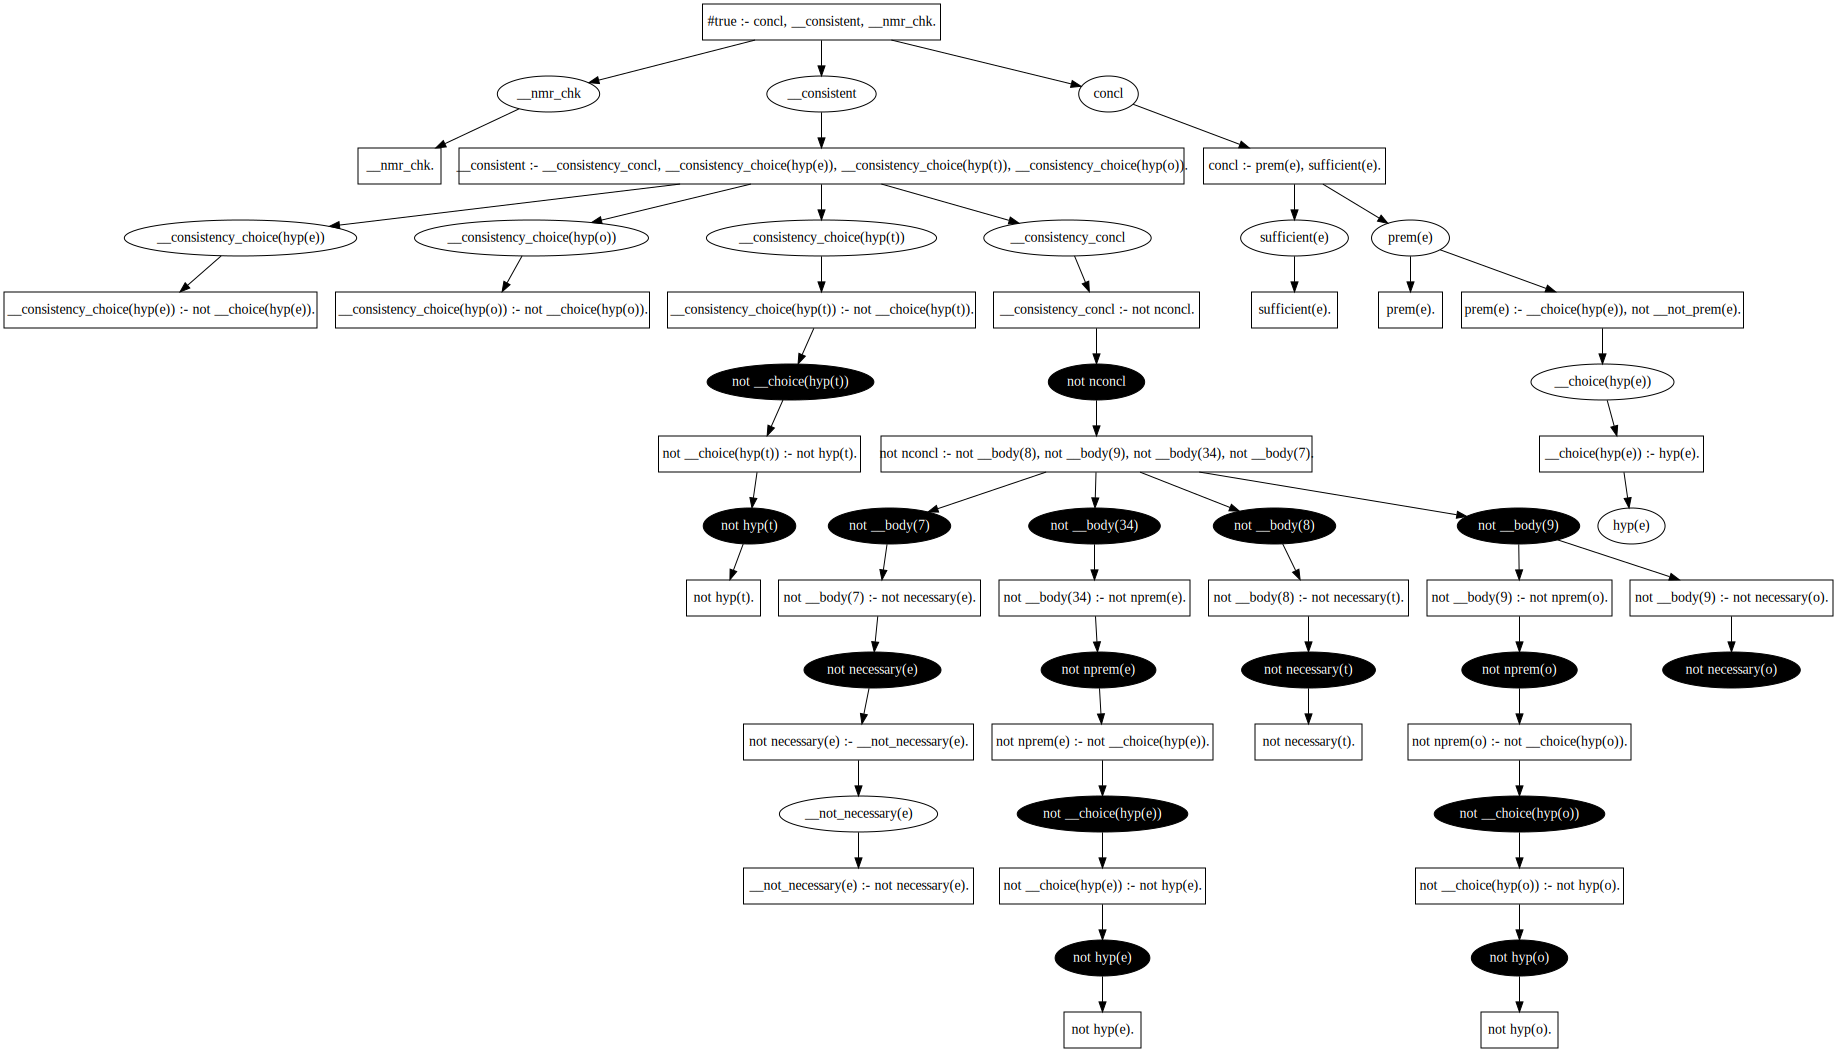

In [20]:
explanation_graph(proof)

Partially enforced consistent proof for concl

In [21]:
proof = tuple(solve(ex_1_1_p, concl, __consistency_concl, models=1))[0]

Answer 0: {
__consistency_concl
__nmr_chk
__not_necessary(e)
concl
prem(e)
sufficient(e)
not __body(34)
not __body(7)
not __body(8)
not __body(9)
not __choice(hyp(e))
not __choice(hyp(o))
not hyp(e)
not hyp(o)
not nconcl
not necessary(e)
not necessary(t)
not nprem(e)
not nprem(o)
}
SAT 1+


In [22]:
explain(proof)

*-- #true :- concl, __consistency_concl, __nmr_chk.
|
|-- concl
  |
  |-- concl :- prem(e), sufficient(e).
    |
    |-- prem(e)
      |
      |-- prem(e) :- __choice(hyp(e)), not __not_prem(e).
        |
        |-- __choice(hyp(e))
          |
          |-- __choice(hyp(e)) :- hyp(e).
            |
            |-- hyp(e)
      |
      |-- prem(e).
        |
        |--[]
    |
    |-- sufficient(e)
      |
      |-- sufficient(e).
        |
        |--[]
|
|-- __consistency_concl
  |
  |-- __consistency_concl :- not nconcl.
    |
    |-- not nconcl
      |
      |-- not nconcl :- not __body(8), not __body(9), not __body(34), not __body(7).
        |
        |-- not __body(8)
          |
          |-- not __body(8) :- not necessary(t).
            |
            |-- not necessary(t)
              |
              |-- not necessary(t).
                |
                |--[]
        |
        |-- not __body(9)
          |
          |-- not __body(9) :- not necessary(o).
            |
   

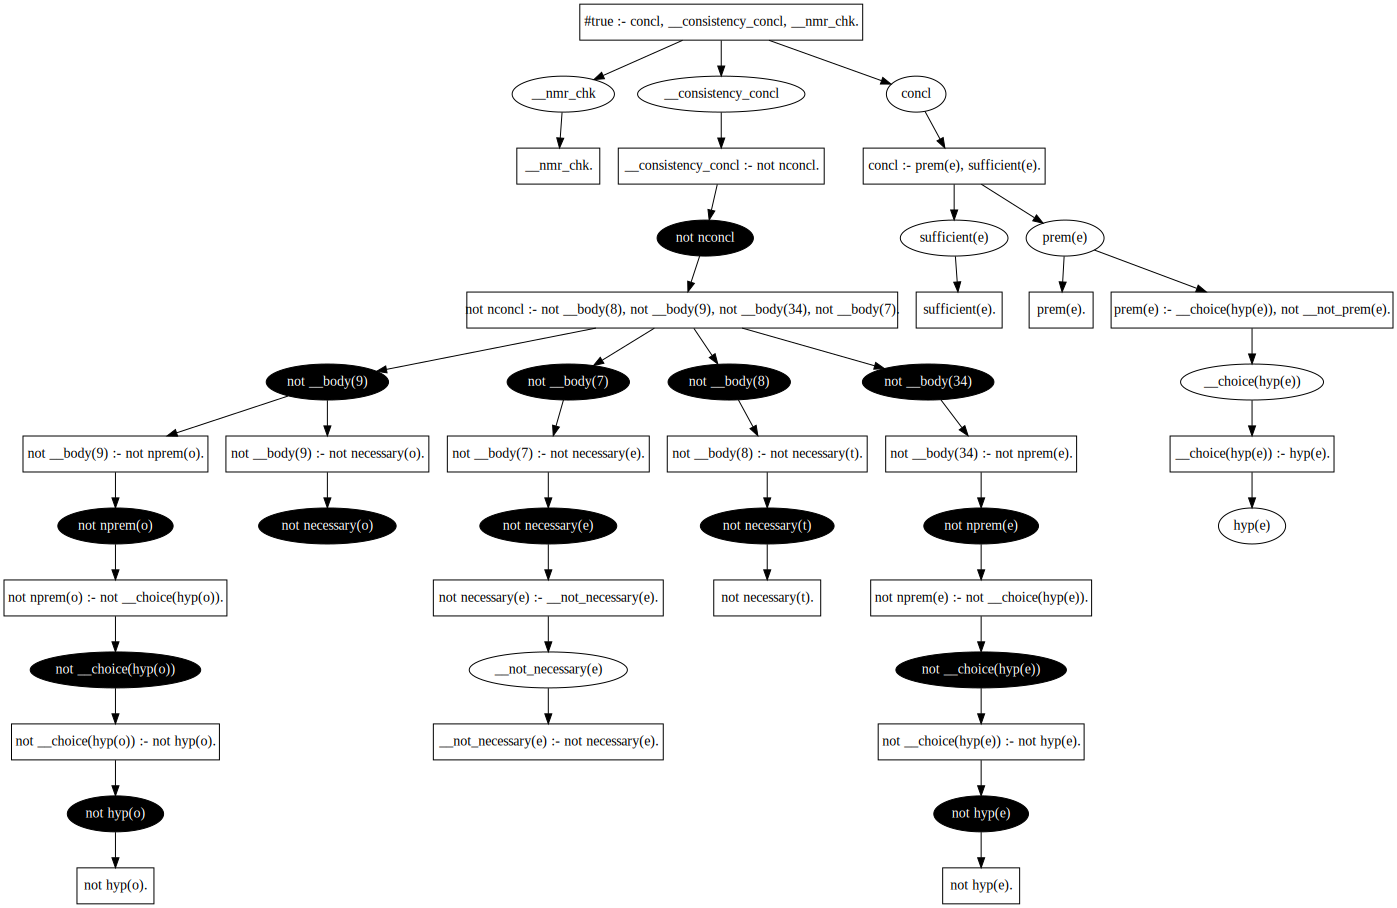

In [23]:
explanation_graph(proof)

Non-enforced consistent proof for concl

In [24]:
proof = tuple(solve(ex_1_1_p, concl, models=1))[0]

Answer 0: {
__nmr_chk
concl
prem(e)
sufficient(e)
}
SAT 1+


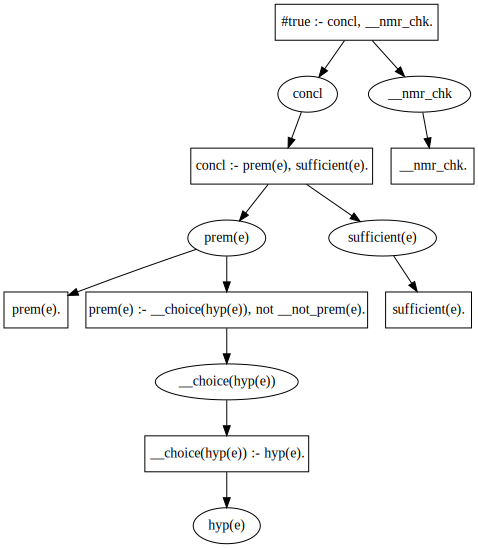

In [25]:
explanation_graph(proof)

In [26]:
proof = tuple(solve(ex_1_1_p, concl, -nprem_e, models=1))[0]

Answer 0: {
__nmr_chk
concl
prem(e)
sufficient(e)
not __choice(hyp(e))
not hyp(e)
not nprem(e)
}
SAT 1+


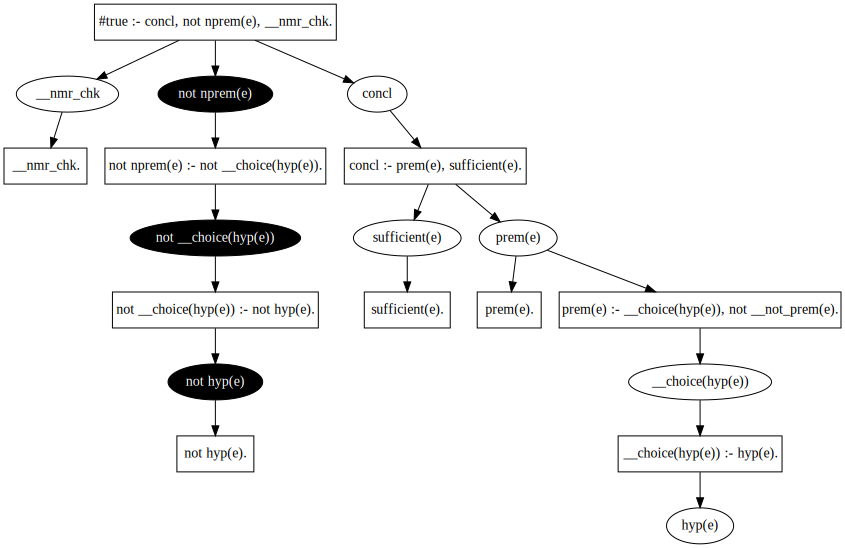

In [27]:
explanation_graph(proof)

We cannot find a proof for nconcl

In [28]:
proof = tuple(solve(ex_1_1_p, nconcl, models=1))

UNSAT


Find a proof for not nconcl

In [29]:
proof = tuple(solve(ex_1_1_p, -nconcl, models=1))[0]

Answer 0: {
__nmr_chk
__not_necessary(e)
not __body(34)
not __body(7)
not __body(8)
not __body(9)
not __choice(hyp(e))
not __choice(hyp(o))
not hyp(e)
not hyp(o)
not nconcl
not necessary(e)
not necessary(t)
not nprem(e)
not nprem(o)
}
SAT 1+


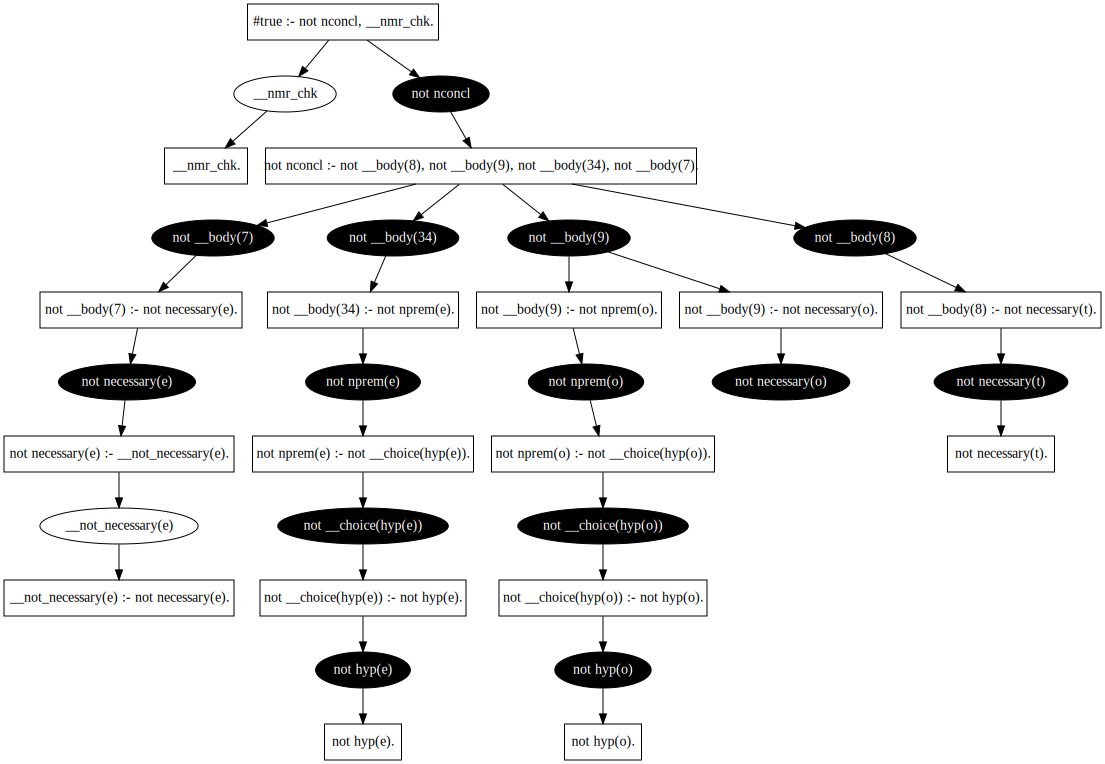

In [30]:
explanation_graph(proof)

This is not necessarily descriptive, because it shows that not nconcl can be derived but not why the opposite cannot be derived.

Question: If we want an consistent partial answer set. Does this derive concl or nconcl?

In [31]:
proof = tuple(solve(ex_1_1_p, __consistent, models=1))[0]

Answer 0: {
__consistency_choice(hyp(e))
__consistency_choice(hyp(o))
__consistency_choice(hyp(t))
__consistency_concl
__consistent
__nmr_chk
__not_necessary(e)
not __body(34)
not __body(7)
not __body(8)
not __body(9)
not __choice(hyp(e))
not __choice(hyp(o))
not __choice(hyp(t))
not hyp(e)
not hyp(o)
not hyp(t)
not nconcl
not necessary(e)
not necessary(t)
not nprem(e)
not nprem(o)
}
SAT 1+


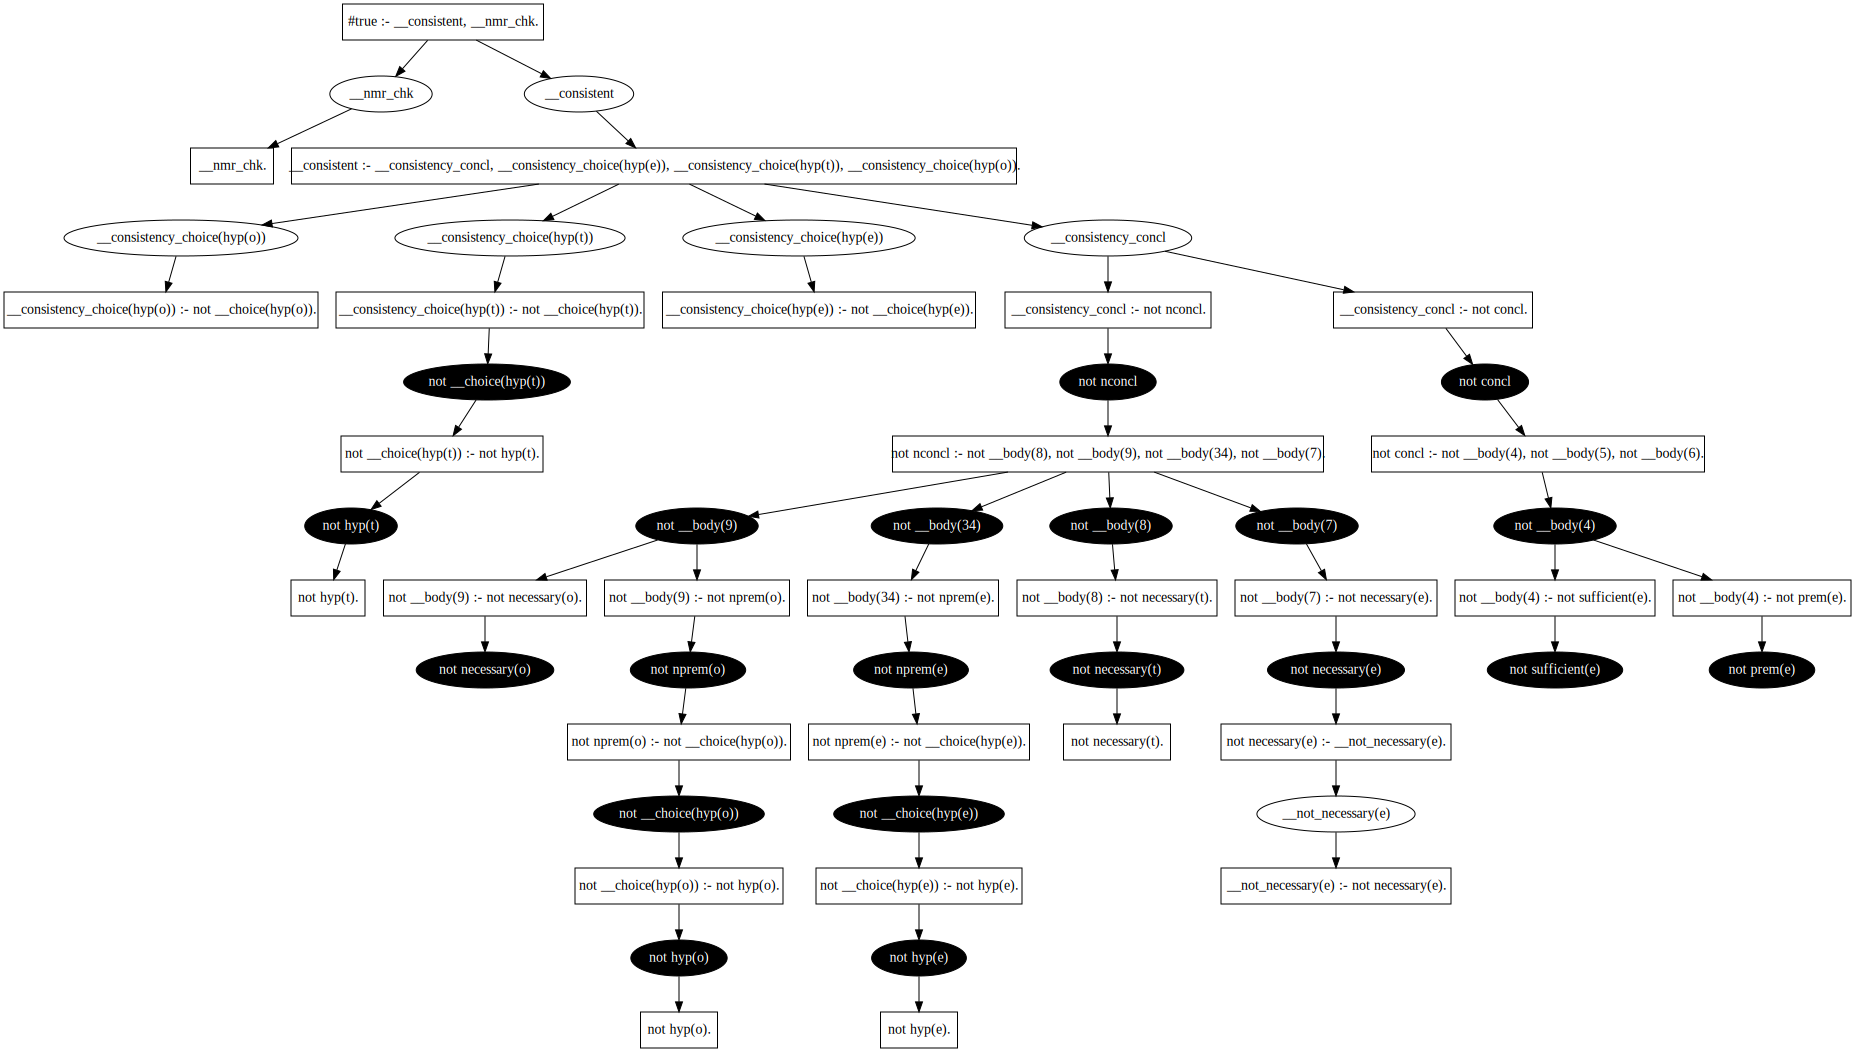

In [32]:
explanation_graph(proof)

We cannot derive `not concl`. Therefore to be consistent we have to derive `not nconcl`.

Second example. If she has a a textbook to finish she will stay late.

In [33]:
ex_1_2_str = """

prem(e).
{hyp(t)}.

query(concl).

"""

hyp_t = Literal(atom=Atom(Symbol('hyp', (t,))))
not_hyp_t = Literal(atom=Atom(Symbol('not_hyp', (t,))))

ex_1_2_rules = (
    NormalRule(prem_e),
    NormalRule(hyp_t, (-not_hyp_t,)),
    NormalRule(not_hyp_t, (-hyp_t,)),
    NormalRule(query_concl),
)

ex_1_2_p = Program((
    *encoding_rules,
    *ex_1_2_rules))

In [34]:
proof = solve(ex_1_2_p, concl, __consistent, models=1)[0]

Answer 0: {
__consistency_choice(hyp(e))
__consistency_choice(hyp(o))
__consistency_choice(hyp(t))
__consistency_concl
__consistent
__nmr_chk
concl
not_hyp(t)
prem(e)
sufficient(e)
not __body(34)
not __body(7)
not __body(8)
not __body(9)
not __choice(hyp(e))
not __choice(hyp(o))
not __choice(hyp(t))
not hyp(e)
not hyp(o)
not hyp(t)
not nconcl
not necessary(e)
not necessary(t)
not nprem(e)
not nprem(o)
}
SAT 1+


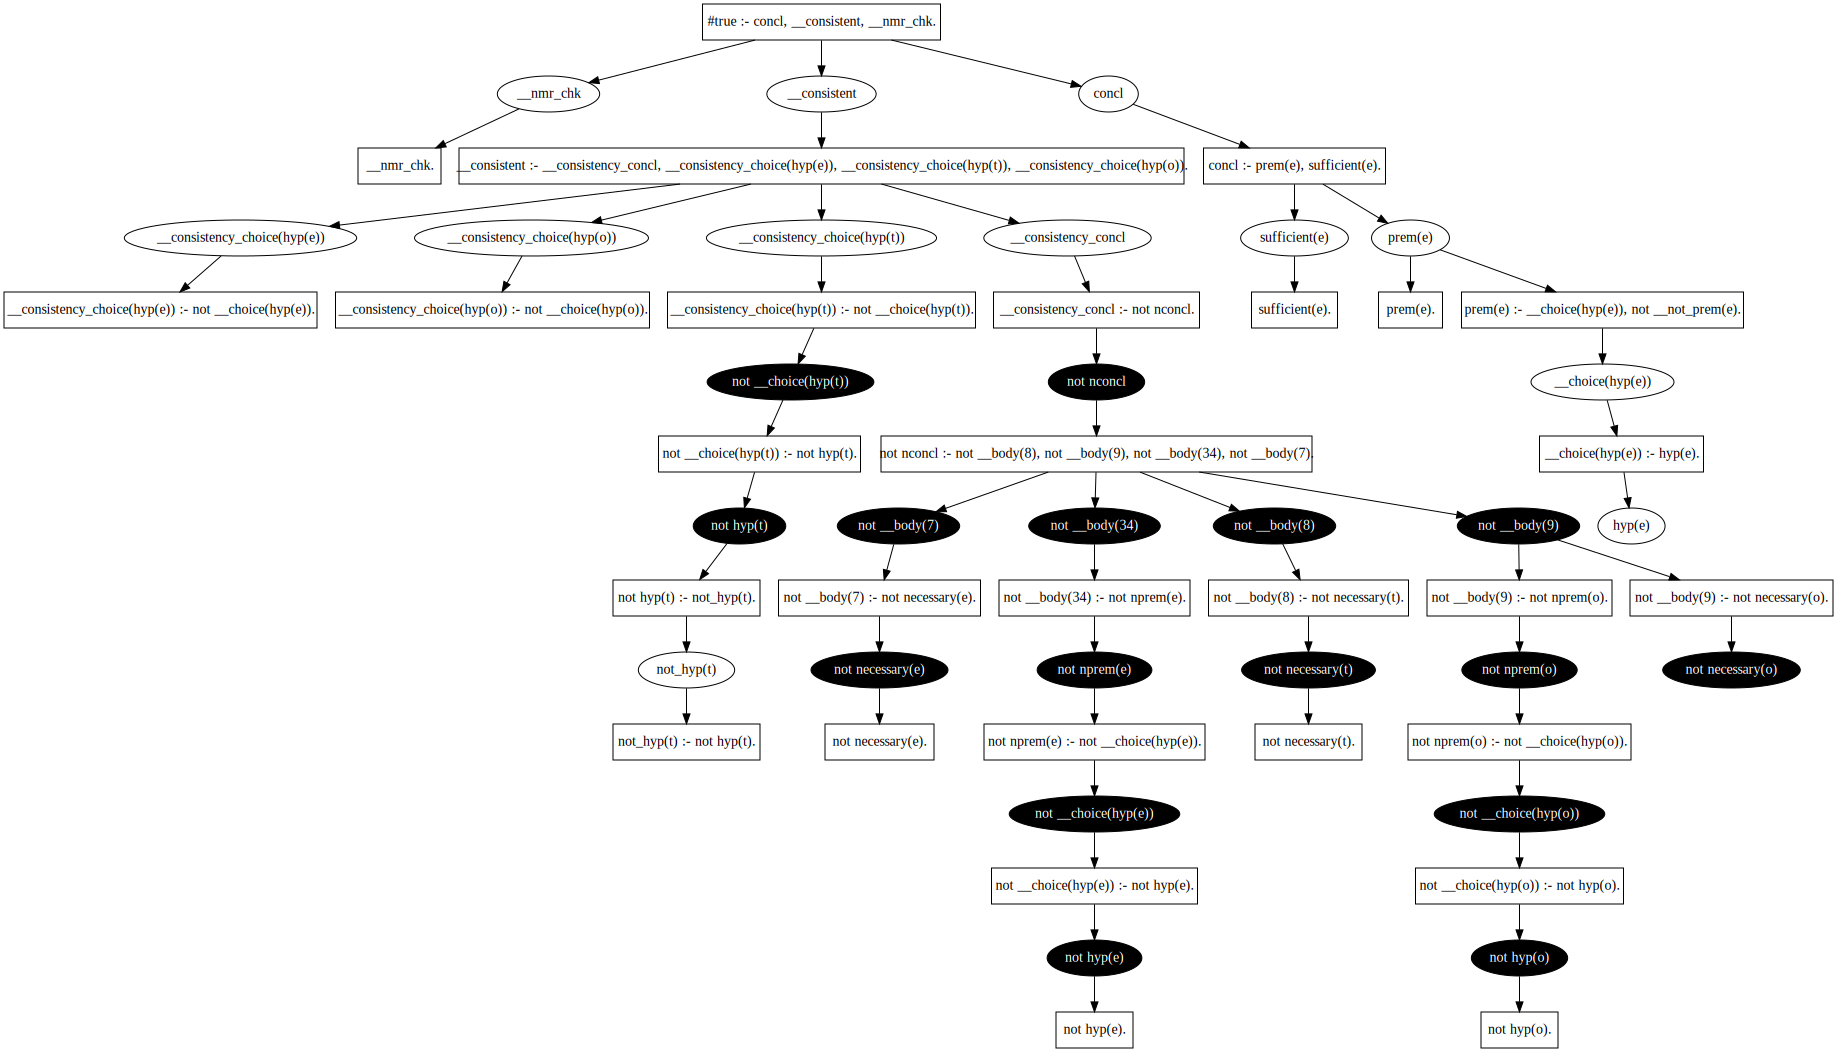

In [35]:
explanation_graph(proof)

It is easy to see that deriving that she has to stay can be independently derived from `sufficient(e)` and `prem(e)`

In [36]:
proof = solve(ex_1_2_p, concl, models=1)[0]

Answer 0: {
__nmr_chk
concl
prem(e)
sufficient(e)
}
SAT 1+


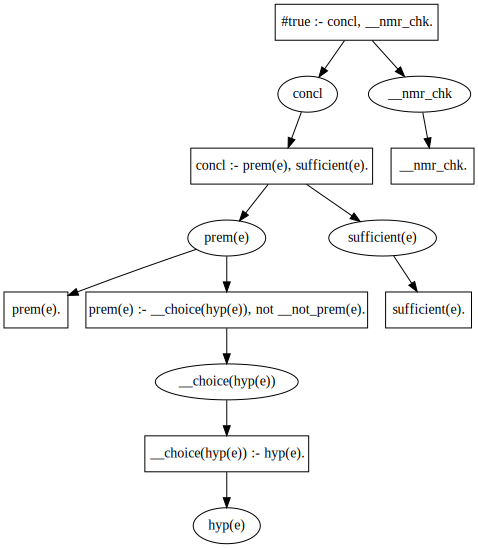

In [37]:
explanation_graph(proof)

In [38]:
proof = solve(ex_1_2_p, concl, prem_t, sufficient_t, models=1)[0]

Answer 0: {
__choice(hyp(t))
__nmr_chk
concl
hyp(t)
prem(e)
prem(t)
sufficient(e)
sufficient(t)
not __not_prem(t)
not not_hyp(t)
}
SAT 1+


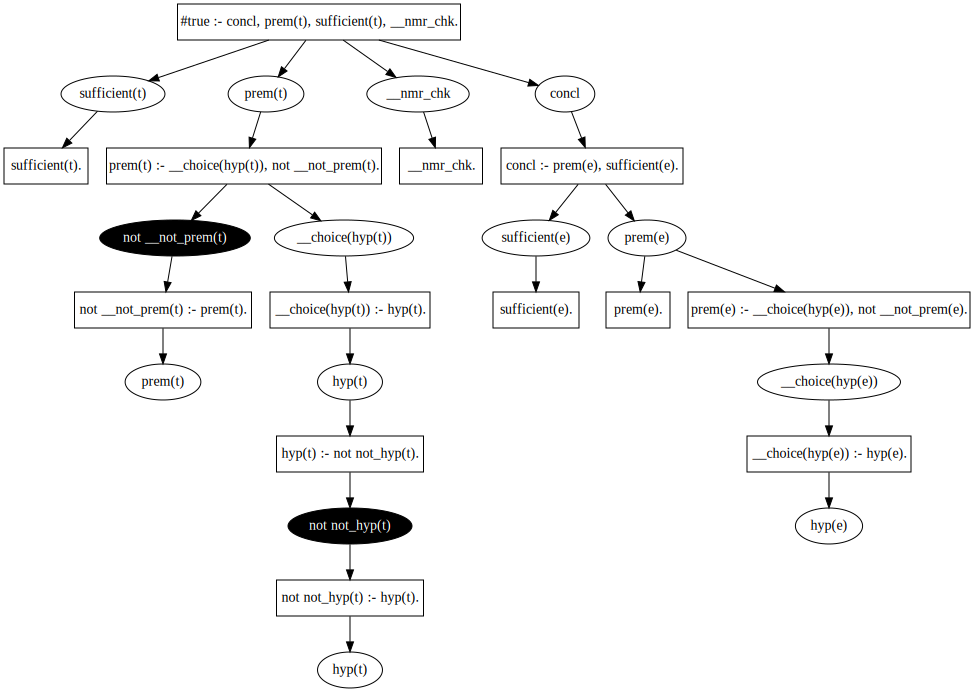

In [39]:
explanation_graph(proof)

In [40]:
proof = solve(ex_1_2_p, concl, nprem_t, models=1)[0]

Answer 0: {
__choice(hyp(t))
__nmr_chk
concl
hyp(t)
nprem(t)
prem(e)
sufficient(e)
not __not_nprem(t)
not not_hyp(t)
}
SAT 1+


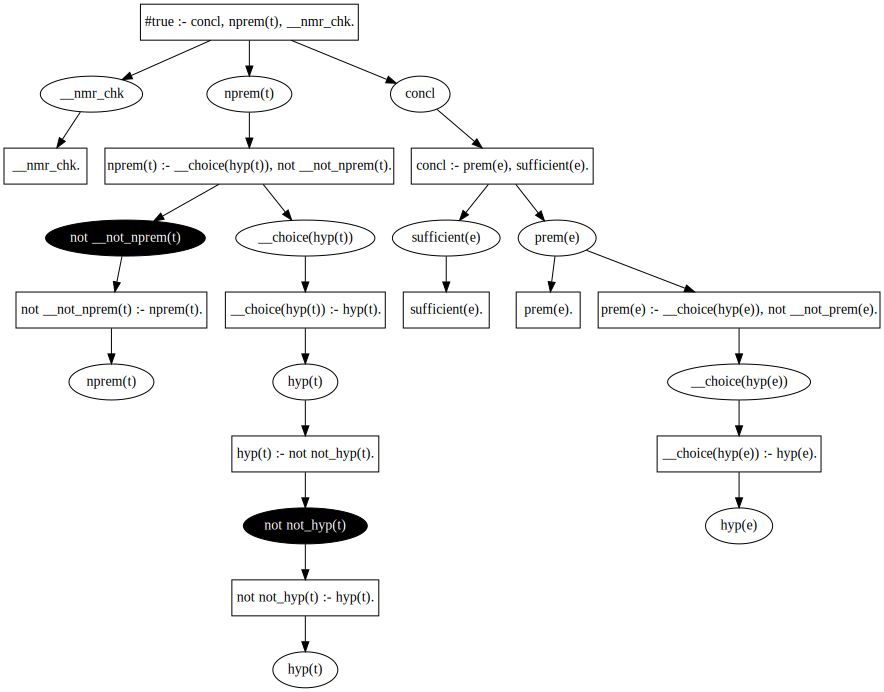

In [41]:
explanation_graph(proof)

In the last example we have the additional information that the library has to be open in order for her to stay late.

In [42]:
ex_1_3_str = """

necessary(e).
{hyp(o);prem(e)}.

query(concl).

"""

hyp_o = Literal(atom=Atom(Symbol('hyp', (o,))))
__not_hyp_o = Literal(atom=Atom(Symbol('__not_hyp', (o,))))

ex_1_3_rules = (
    NormalRule(necessary_e),
    NormalRule(hyp_o, (-__not_hyp_o,)),
    NormalRule(__not_hyp_o, (-hyp_o,)),
    NormalRule(prem_e, (-__not_prem_e,)),
    NormalRule(__not_prem_e, (-prem_e,)),
    NormalRule(query_concl),
)

ex_1_3_p = Program(
    (*encoding_rules,
     *ex_1_3_rules))

We can still proof `concl`.

In [43]:
proof = tuple(solve(ex_1_3_p, concl, models=1))[0]

Answer 0: {
__nmr_chk
concl
prem(e)
sufficient(e)
not __body(12)
not __choice(hyp(e))
not __not_prem(e)
not hyp(e)
}
SAT 1+


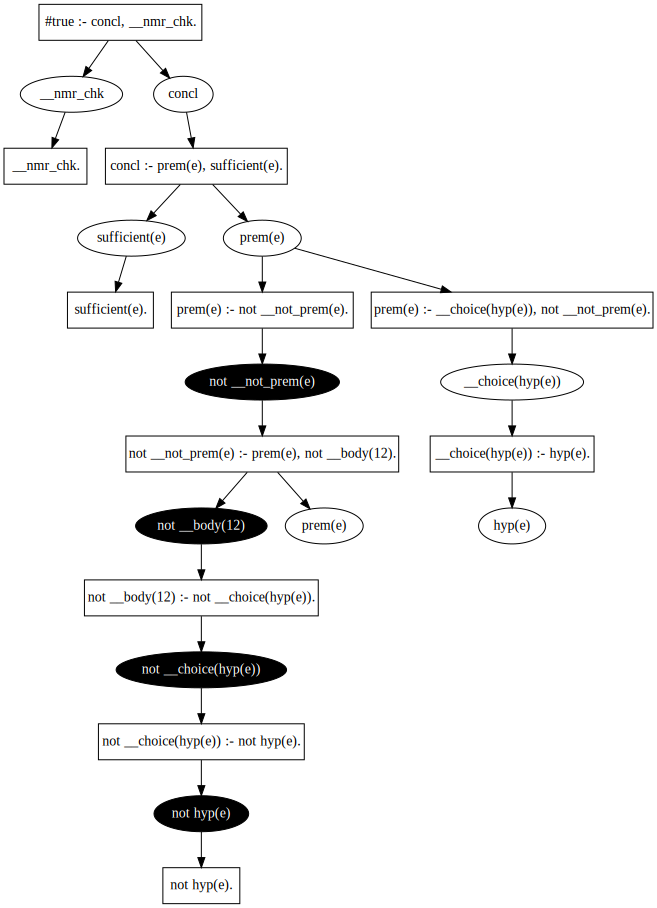

In [44]:
explanation_graph(proof)

However `prem(e)` is no longer a fact, so it has to be derived elsewhere.

Additionally we can now derive `nconcl`.

In [45]:
proof = tuple(solve(ex_1_3_p, nconcl, models=1))[0]

Answer 0: {
__choice(hyp(o))
__nmr_chk
hyp(o)
nconcl
necessary(o)
nprem(o)
not __not_hyp(o)
not __not_nprem(o)
}
SAT 1+


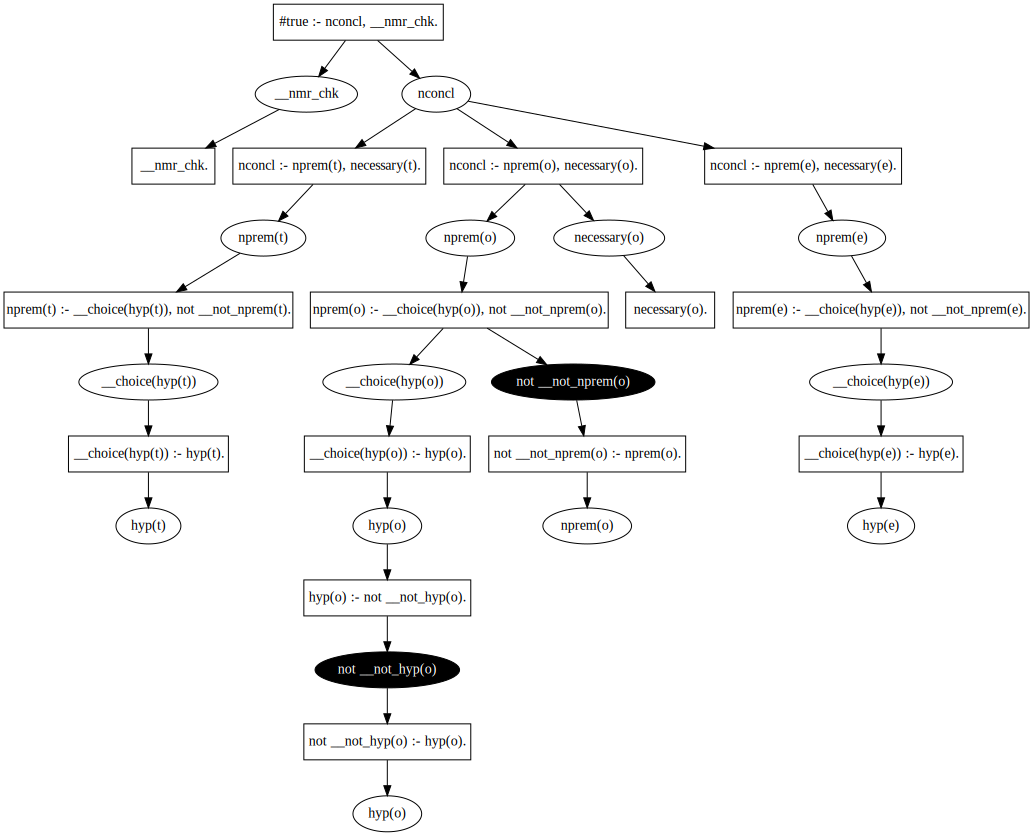

In [46]:
explanation_graph(proof)

In [47]:
proof = tuple(solve(ex_1_3_p, nconcl, __consistent, models=1))[0]

Answer 0: {
__choice(hyp(o))
__consistency_choice(hyp(e))
__consistency_choice(hyp(o))
__consistency_choice(hyp(t))
__consistency_concl
__consistent
__nmr_chk
__not_prem(e)
__not_prem(o)
hyp(o)
nconcl
necessary(o)
nprem(o)
not __body(11)
not __body(4)
not __body(5)
not __body(6)
not __choice(hyp(e))
not __choice(hyp(t))
not __not_hyp(o)
not __not_nprem(o)
not concl
not hyp(e)
not hyp(t)
not prem(e)
not prem(o)
not prem(t)
}
SAT 1+


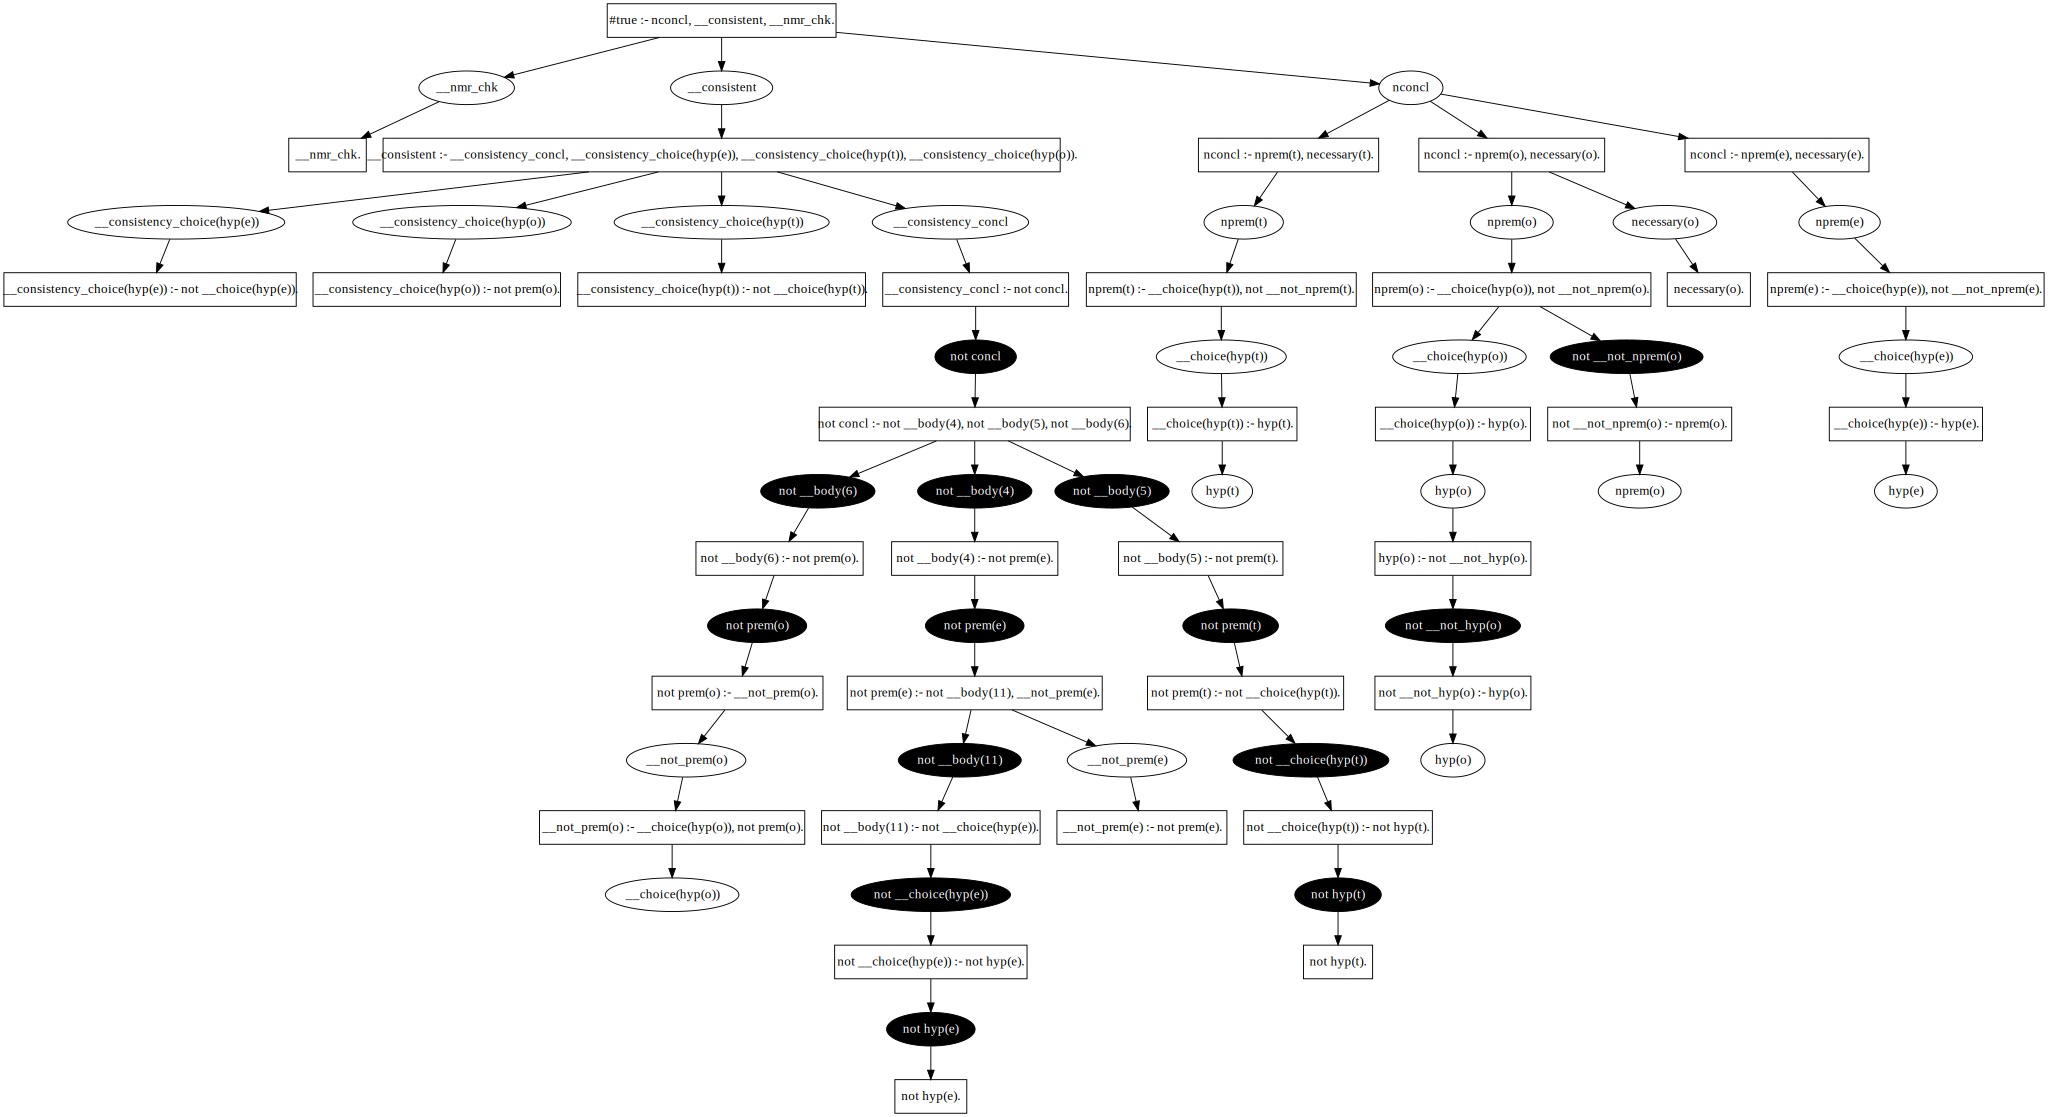

In [48]:
explanation_graph(proof)